<a href="https://colab.research.google.com/github/CJ-Kaufman/INDE577_2024/blob/main/Supervised_Learning/Logistic%20Regression/Refined_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression Implementation
## Introduction
Logistic regression is like linear regression in terms of it being able to be used for binary classification, but in this case where the data is not linearly separable, we implement a probabilistic classification. Before a certain point in one data parameter, the points are more likely to be one type, and after they are more likely to be another. Implementing the sigmoid function for this grey area of overlap in the classification data yeilds a probability with useful insight.

## Imports and Data Loading

Saving palmer_penguins.csv to palmer_penguins.csv


<ipython-input-2-d8441f5c0e25>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chinstrap_df["body_mass_kg"] = chinstrap_df["body_mass_g"] / 1000
<ipython-input-2-d8441f5c0e25>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gentoo_df["body_mass_kg"] = gentoo_df["body_mass_g"] / 1000
<ipython-input-2-d8441f5c0e25>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

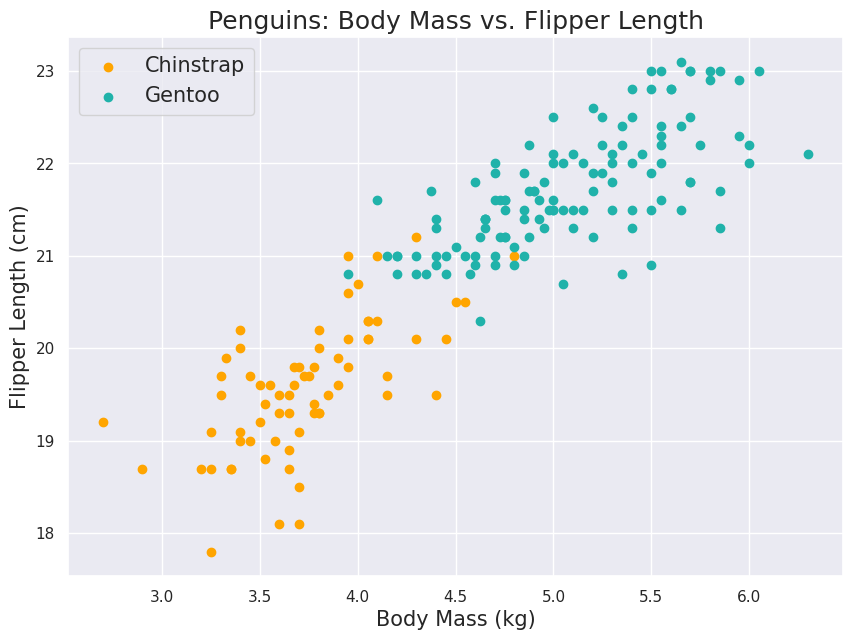

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files
uploaded = files.upload()

sns.set_theme()

# Load the data
df = pd.read_csv("palmer_penguins.csv")

# Filter the dataframe for Chinstrap and Gentoo species
chinstrap_df = df[df["species"] == "Chinstrap"]
gentoo_df = df[df["species"] == "Gentoo"]

# Convert body mass from grams to kilograms
chinstrap_df["body_mass_kg"] = chinstrap_df["body_mass_g"] / 1000
gentoo_df["body_mass_kg"] = gentoo_df["body_mass_g"] / 1000

# Convert flipper length from millimeters to centimeters
chinstrap_df["flipper_length_cm"] = chinstrap_df["flipper_length_mm"] / 10
gentoo_df["flipper_length_cm"] = gentoo_df["flipper_length_mm"] / 10

# Create the plot
plt.figure(figsize = (10, 7))

# Scatter plot for Chinstrap penguins
plt.scatter(chinstrap_df["body_mass_kg"],
            chinstrap_df["flipper_length_cm"],
            color = "orange",
            label = "Chinstrap")

# Scatter plot for Gentoo penguins
plt.scatter(gentoo_df["body_mass_kg"],
            gentoo_df["flipper_length_cm"],
            color = "lightseagreen",
            label = "Gentoo")

# Labels and title
plt.xlabel("Body Mass (kg)", fontsize = 15)
plt.ylabel("Flipper Length (cm)", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Penguins: Body Mass vs. Flipper Length", fontsize = 18)

# Show plot
plt.show()


Unlike the perceptron example, this data is not linearly separable. Let's eliminate the flipper length and just work with the body mass as our variable.

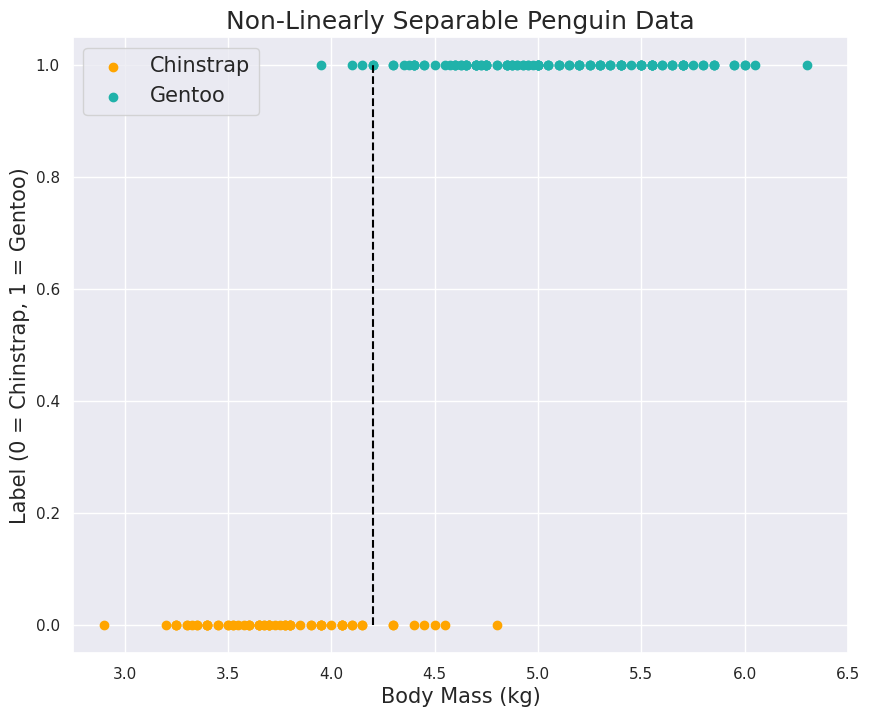

In [3]:
# Create the plot
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 6.5))  # Set x-axis limits similar to the example

# Scatter plot for Chinstrap penguins (y=0)
plt.scatter(chinstrap_df["body_mass_kg"],
            np.zeros(len(chinstrap_df)),  # Set all y-values to 0
            color = "orange",
            label = "Chinstrap")

# Scatter plot for Gentoo penguins (y=1)
plt.scatter(gentoo_df["body_mass_kg"],
            np.ones(len(gentoo_df)),  # Set all y-values to 1
            color = "lightseagreen",
            label = "Gentoo")

# Vertical line to show non-linear separability
plt.vlines(4.2, 0.0, 1.0, color='black', linestyle="--")

# Labels and title
plt.xlabel("Body Mass (kg)", fontsize = 15)
plt.ylabel("Label (0 = Chinstrap, 1 = Gentoo)", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Separable Penguin Data", fontsize = 18)

# Show plot
plt.show()


Above is a visualization of a potential line of separation. However, as you can tell, some Chinstrap penguins fall above the line and some Gentoo below, so the information isn't exact. Enter the sigmoid function, as seen below, which can be implemeneted as logistic regression to indicate where data points are more certain and where they are likely to overlap.

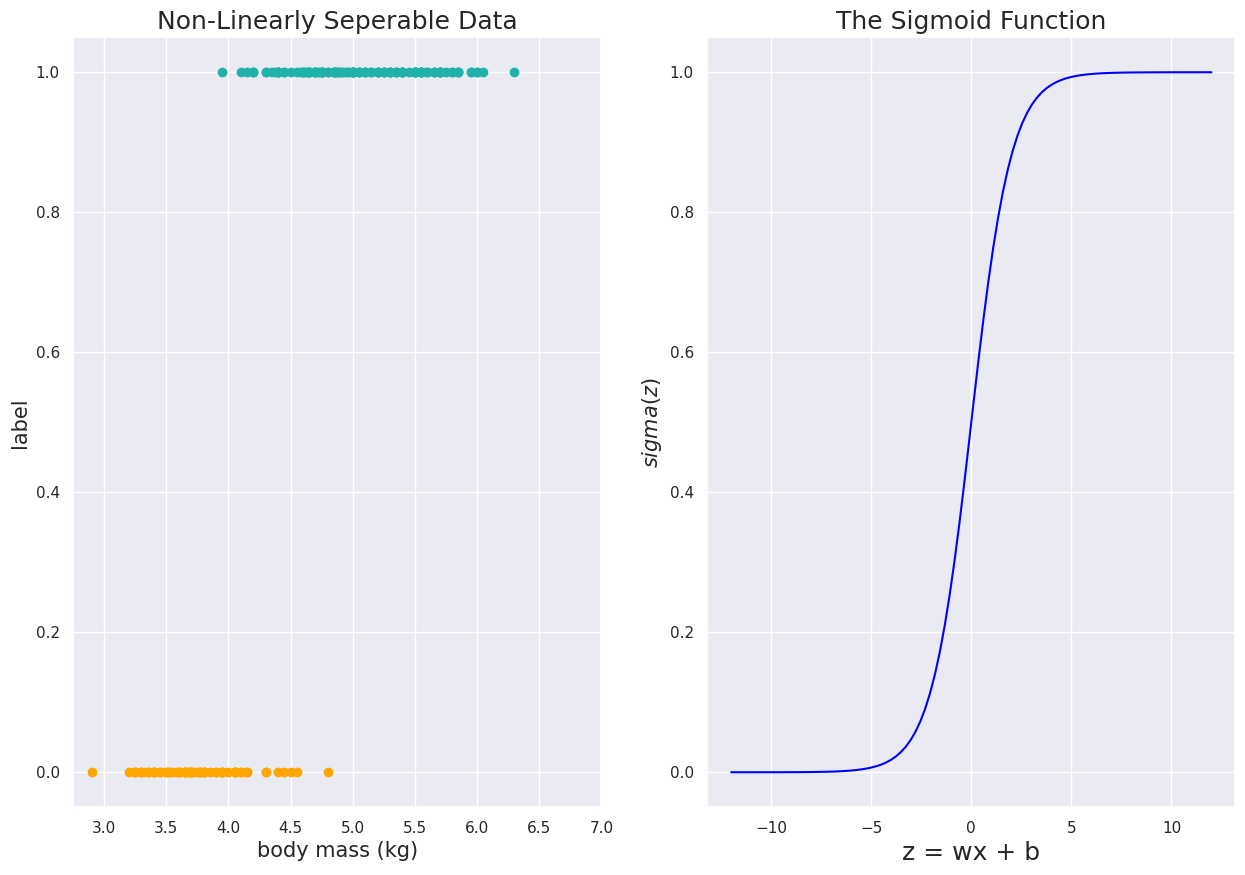

In [5]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_xlim((2.75, 7))
ax1.scatter(chinstrap_df["body_mass_kg"],
            np.zeros(len(chinstrap_df)),
            color = "orange",
            label = "chinstrap")
ax1.scatter(gentoo_df["body_mass_kg"],
            np.ones(len(gentoo_df)),
            color = "lightseagreen",
            label = "gentoo")
ax1.set_xlabel("body mass (kg)", fontsize = 15)
ax1.set_ylabel("label", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain,
        sigmoid(domain),
        color = "blue",
        label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("The Sigmoid Function", fontsize = 18)
plt.show()

This shows a basic sigmoid function to visualize how it could line up with the penguin data, but it has not yet been trained on this data set.

## Training with Data

Below is a Single Neuron class which includes functions to initialize and train the model using a preactivation values and determining errors, or costs, to improve over time training (epochs). The model is then trained on the data, after it has been shaped correctly with any nan values removed.

In [6]:
# Example data setup
X = pd.concat([chinstrap_df["body_mass_kg"], gentoo_df["body_mass_kg"]], axis=0).values
X = X.reshape(-1, 1)  # Reshaped to a 2D array for training
y = np.concatenate([np.zeros(len(chinstrap_df)), np.ones(len(gentoo_df))])

# Combine X and y into a single DataFrame for viewing
data = pd.DataFrame({'X': X.flatten(), 'y': y})

# Remove row 187 from both X and y, which has an erroneous value
X_clean = np.delete(X, 187, axis=0)
y_clean = np.delete(y, 187, axis=0)

class SingleNeuron(object):
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X_clean, y_clean, alpha=0.005, epochs=50):
        self.w_ = np.array([0.01, 0.01])  # Initializing weights to small values
        self.errors_ = []
        N = X.shape[0]

        for epoch in range(epochs):
            errors = 0
            for xi, target in zip(X_clean, y_clean):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha * error * xi
                self.w_[-1] -= alpha * error
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors / N)
        return self

    def predict(self, X_clean):
        preactivation = np.dot(X_clean, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1),
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

# Cross entropy loss function
def cross_entropy_loss(y_hat, y_clean):
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)  # To prevent log(0)
    return -y_clean * np.log(y_hat) - (1 - y_clean) * np.log(1 - y_hat)

node = SingleNeuron(sigmoid, cross_entropy_loss)

# Start training
node.train(X_clean, y_clean, alpha=0.01, epochs=10000)



## Visualizing Training and Results
Let's check that our trained model looks reasonable at a first glance. Body mass of around 3 kg should all be classified as Chinstrap, which is identified as 0, so that looks good so far...

In [ ]:
print(f"First few X values: {X[:5]}")
print(f"First few y values: {y[:5]}")

First few X values: [[3.5  ]
 [3.9  ]
 [3.65 ]
 [3.525]
 [3.725]]
First few y values: [0. 0. 0. 0. 0.]


Next, we can visualize how the movel improved during training by plotting the descent of the cost (or error) by epoch.

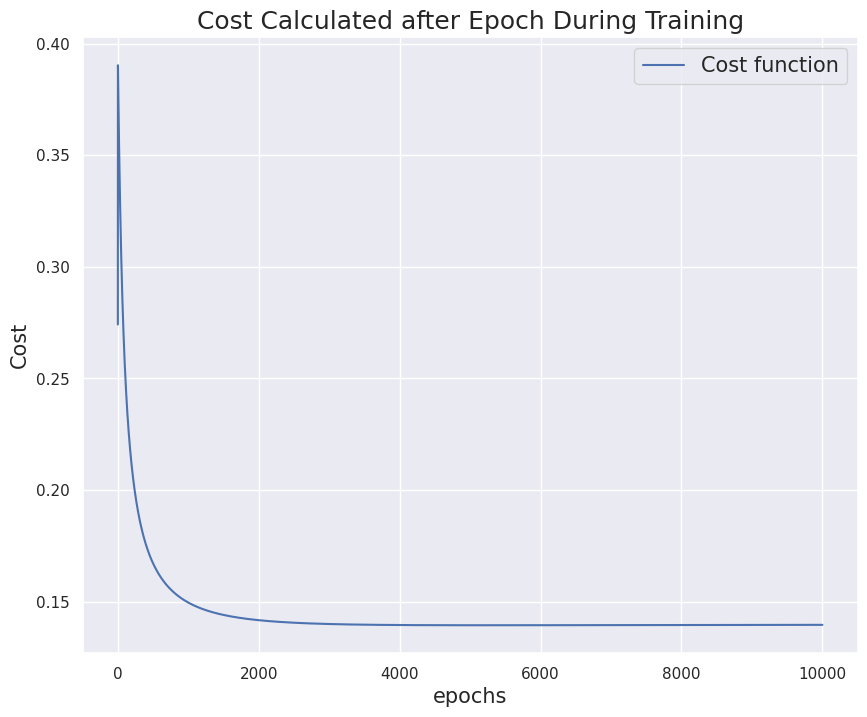

In [ ]:
node.plot_cost_function()
plt.show()

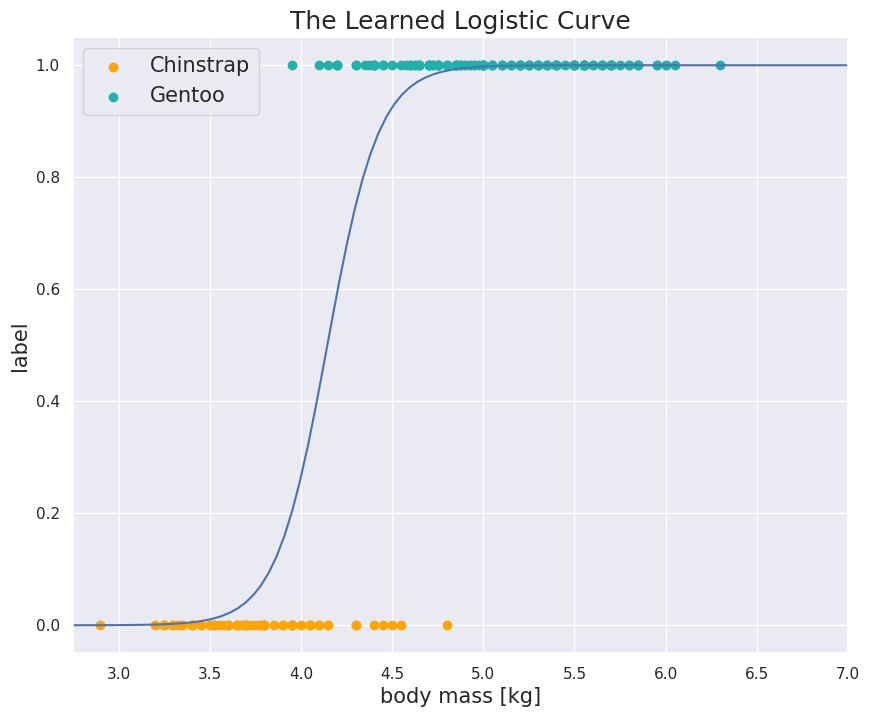

In [ ]:
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 7 ))
plt.scatter(chinstrap_df["body_mass_kg"],
            np.zeros(len(chinstrap_df)),  # Set all y-values to 0
            color = "orange",
            label = "Chinstrap")
plt.scatter(gentoo_df["body_mass_kg"],
            np.ones(len(gentoo_df)),  # Set all y-values to 1
            color = "lightseagreen",
            label = "Gentoo")

domain = np.linspace(2.75, 7, 100)
plt.plot(domain, node.predict(domain.reshape(-1, 1)))
plt.xlabel("body mass [kg]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("The Learned Logistic Curve", fontsize = 18)
plt.show()


Putting it all together, the plot with out trained sigmoid function overlayed looks good! Body mass over about 4.2 is more likely to be classified as Gentoo, with increasing certainty (like a percentage of the logistic curve on the y axis since it's scaled from 0 to 1) as the number goes up.

In [ ]:
node.predict(X_clean)

array([1.04290848e-02, 1.50912091e-01, 2.95057581e-02, 1.24181847e-02,
       4.91026274e-02, 2.01923704e-01, 1.79953161e-03, 5.80352036e-02,
       5.09571220e-01, 4.14843725e-02, 8.06337588e-02, 6.84757447e-02,
       4.14843725e-02, 3.38942049e-01, 1.75853643e-02, 3.38942049e-01,
       2.55976506e-03, 4.14843725e-02, 7.34893448e-03, 8.58640539e-01,
       2.09105130e-02, 5.17372685e-03, 1.52151079e-04, 8.06337588e-02,
       2.55976506e-03, 5.09571220e-01, 5.17372685e-03, 8.06337588e-02,
       4.14843725e-02, 9.46012193e-01, 1.26479621e-03, 7.49836867e-01,
       3.63999697e-03, 4.21928571e-01, 2.09105130e-02, 1.50912091e-01,
       1.10995149e-01, 9.90332318e-01, 3.70543309e-05, 9.24863957e-01,
       2.01923704e-01, 2.95057581e-02, 1.47809916e-02, 1.04290848e-02,
       3.50045762e-02, 8.96339240e-01, 5.17372685e-03, 7.49836867e-01,
       1.79953161e-03, 3.50045762e-02, 3.05260929e-03, 2.01923704e-01,
       2.09105130e-02, 3.38942049e-01, 3.63999697e-03, 7.34893448e-03,
      

In [ ]:
np.rint(node.predict(X_clean)) != y_clean

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False,  True, False,  True, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Above shows the number of times our model classified something incorrectly based on the probabilities. Below shows our overall classification error- pretty good, about 5.76%

In [ ]:
classification_error = (np.rint(node.predict(X_clean)) != y_clean).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y_clean)}")

Classification Error = 0.05759162303664921


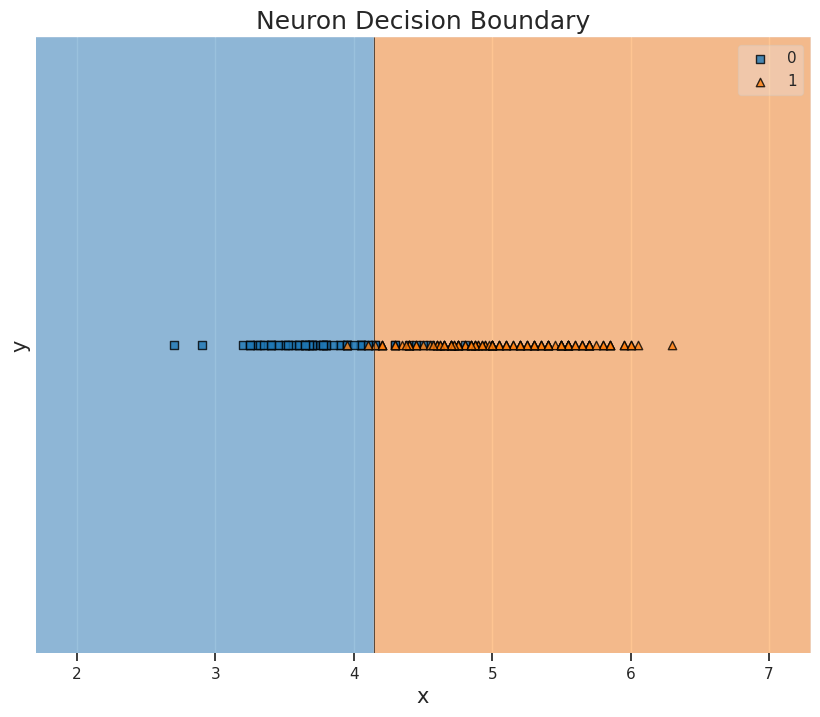

In [7]:
def plot_decision_boundary(self, X_clean, y_clean, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plt.xlim((2.75, 7 ))
        plot_decision_regions(X_clean, y_clean, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()
from mlxtend.plotting import plot_decision_regions

# Find the indices where the value in X_clean has an overstack outlier
outlier_index = np.where(X_clean == -9223372036854775808)[0]

# Remove the row with that specific value from both X_clean and y_clean
X_clean = np.delete(X_clean, outlier_index, axis=0)
y_clean = np.delete(y_clean, outlier_index, axis=0)

node.plot_decision_boundary(X_clean, y_clean.astype(int))
plt.show()

Based on the trained logistic curve, anything in the blue region of the above graph is more likely to be a chinstrap while anything in the orange region is more likely to be a gentoo, and therefore will be classified as such. Logistic regression can also be used with multiple inputs, and is useful for implementation when data is not linearly seperable but is still grouped on average around different values with minimal overlap.